# Clasificación Supervizada de Objetos Astronómicos

INFO257 - Inteligencia Artificial<br>
<b>Autor:</b> Eduardo Hopperdietzel

<img src="background.jpg" style="width:100%">

El objetivo de este trabajo es analizar la calidad y eficiencia de los sigientes algoritmos de clasificación supervisada:<br>
* Regresión Logística
* K-Nearest Neighbors
* Árbol de decisión

Para esto, se estudiará un caso en especifico; La clasificación de objetos astronómicos, (dada sus carácterisitcas), en una de las 3 siguientes categorías:

* Estrella.
* Galaxia.
* Quasar.

Se tiene a disposición un dataset con 10.000 observaciones registradas por la SDSS, el cual se utilizará para <i>"entrenar"</i> y <i>"probar"</i> cada uno de los modelos.

## Librerías

Para instalar módulo imblearn:
```shell
conda install -c conda-forge imbalanced-learn
```

In [19]:
# Manejo Dataset
import pandas as pd
import numpy as np
from sklearn import datasets
import urllib

# Gráficas
import seaborn as sn
import matplotlib.pyplot as plt

# Preprocesamiento
import scipy
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Algoritmos / modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from pylab import rcParams
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Medición
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score



## Importación del Dataset

In [2]:
df = pd.read_csv("SDSS-DR14.csv")
df[:4]

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510


## Descripción de los Parámetros

A continuación se detalla el significado de cada parámetro de las observaciones, indicando su tipo y si será utilizado posteriormente por los modelos.

<table style="float:left">
    <tr style="background:#444;color:white">
        <th>Parámetro</th>
        <th>Descripción</th>
        <th>Tipo de Variable</th>
        <th>Utilizada</th>
    </tr>
    <tr>
        <td style='font-weight:bold'>objid:</td>
        <td>Id de la tabla de la cual proviene el dataset.</td>
        <td>Discreta</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>ra:</td>
        <td>Ángulo de ascensión recta. <a href="https://en.wikipedia.org/wiki/Right_ascension">Más Info</a></td>
        <td>Continua</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>dec:</td>
        <td>Ángulo de declinación. <a href="https://en.wikipedia.org/wiki/Declination">Más Info</a></td>
        <td>Continua</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>u:</td>
        <td>Intensidad del espectro ultravioleta.</td>
        <td>Continua</td>
        <td>Si</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>g:</td>
        <td>Intensidad del espectro verde.</td>
        <td>Continua</td>
        <td>Si</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>r:</td>
        <td>Intensidad del espectro rojo.</td>
        <td>Continua</td>
        <td>Si</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>i:</td>
        <td>Intensidad del espectro infrarojo.</td>
        <td>Continua</td>
        <td>Si</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>z:</td>
        <td>Intensidad del espectro infrarojo lejano.</td>
        <td>Continua</td>
        <td>Si</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>run:</td>
        <td>Largo de la tira actual (ID del escaneo). <a href="https://www.sdss.org/dr16/imaging/imaging_basics/">Más Info</a></td>
        <td>Discreta</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>rerun:</td>
        <td>Tipo de reprocesamieto del <i>"run"</i>. <a href="https://www.sdss.org/dr16/help/glossary/#rerun">Más Info</a></td>
        <td>Discreta</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>camcol:</td>
        <td>ID de una de las 6 tiras de la cámara utilizada en la captura. <a href="https://www.sdss.org/dr16/help/glossary/#camcol">Más Info</a></td>
        <td>Discreta</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>field:</td>
        <td>Fragmento o parte de la tira. <a href="https://www.sdss.org/dr16/help/glossary/#field">Más Info</a></td>
        <td>Discreta</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>specobjid:</td>
        <td>ID del objeto espectroscópico. <a href="https://www.sdss.org/dr16/help/glossary/#specobj">Más Info</a></td>
        <td>Discreta</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>class:</td>
        <td>Objeto astronómico detectado.</td>
        <td>Categórica</td>
        <td>Si</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>redshift:</td>
        <td>Velocidad de recesión ( Sirve como medida de distancia a la Tierra ). <a href="https://es.qwe.wiki/wiki/Recessional_velocity">Más Info</a></td>
        <td>Continua</td>
        <td>Si</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>plate:</td>
        <td>ID de la placa utilizada en la captura. <a href="https://blog.sdss.org/2014/09/19/sdss-plates/">Más Info</a></td>
        <td>Discreta</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>mjd:</td>
        <td>Fecha Juliana modificada, de la noche en que se realizó la observación. <a href="http://scienceworld.wolfram.com/astronomy/ModifiedJulianDate.html">Más Info</a></td>
        <td>Discreta</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>fiberid:</td>
        <td>Id del cable de la placa que realizó la captura.</td>
        <td>Discreta</td>
        <td>No</td>
    </tr>
</table>




## Filtración de Parámetros

Se puede intuir que parámetros que contienen ID's, características sobre la placa utilizada o sobre la estructura de la imagen, y fechas, no aportan información reelevante al problema **( objid, run, rerun, camcol, field, specobjid, plate, mjd, fiberid )**.

Lo mismo ocurre con los parámetros **ra** y **dec**, los cuales indican las coordenadas espaciales de la observación.<br>
Podría ocurrir que en ciertas coordenadas, exista una mayor concentración de objetos astronomicos de algun tipo, en cuyo caso los parámetros podrían ser de utilidad, sin embargo el enfoque del problema es detectar objetos independiente de su ubicación.

Parámetros que sí podrían aportar información reelevante, son los que contienen mediciones de distintos rangos del especto electromagnético **( u, g, r, i, z )**, ya que según la cantidad de cada uno, se puede deducir la composición química del objeto observado, y por ende su tipo.

Otro parámetro que puede ser de utilidad es **redshift**, el cual aporta información respecto a la velocidad con la que el objeto se acerca o aleja de la Tierra, lo cual puede indicar el por qué, de las variaciones en las mediciones de los espectros electromagneticos.

Por último, utilizaremos el parámetro **class**, la cuál será la <i>"variable"</i> dependiente a estudiar **( Y )**.

In [3]:
# Variable objetivo
Y = df["class"]

# Variables predictivas
X = df[['u','g','r','i','z','redshift']]

Analizamos la relación entre las variables y las clases.

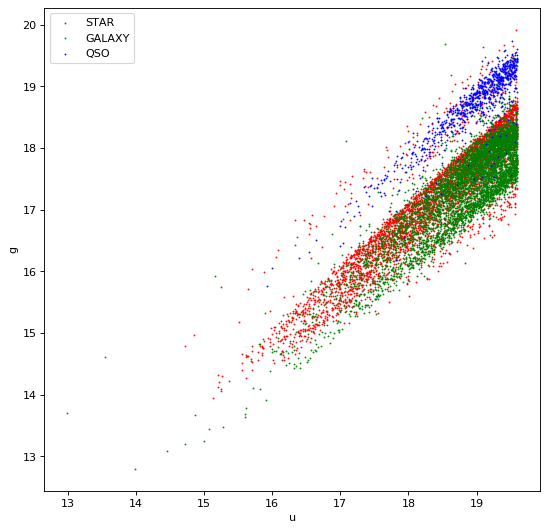

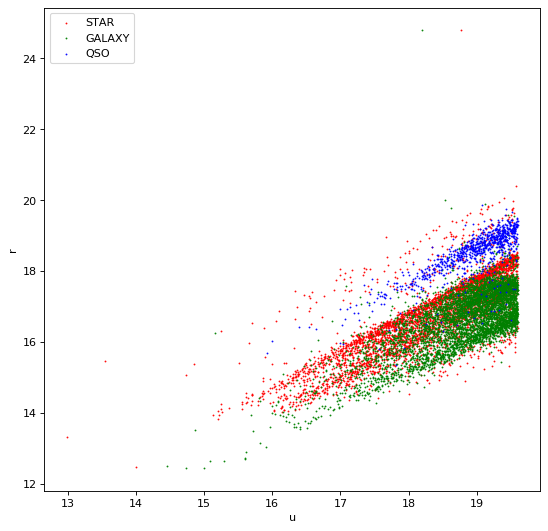

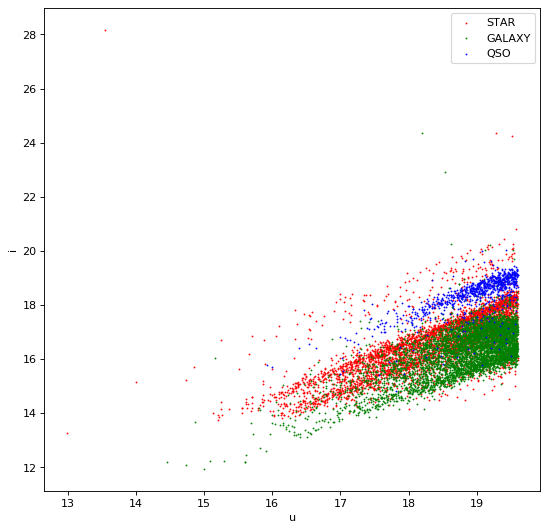

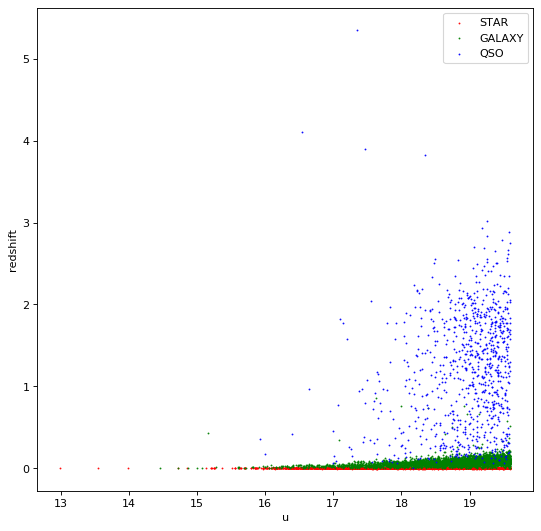

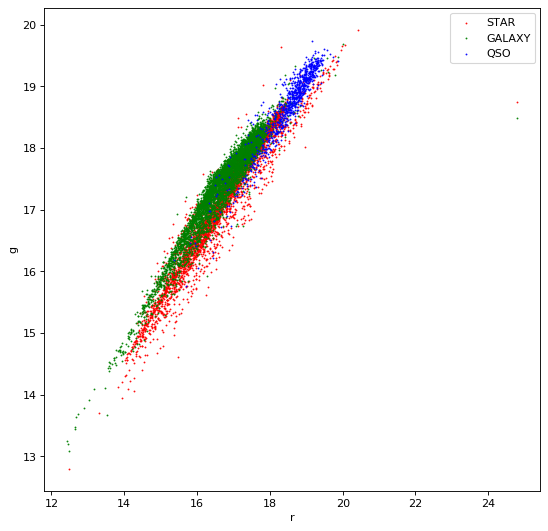

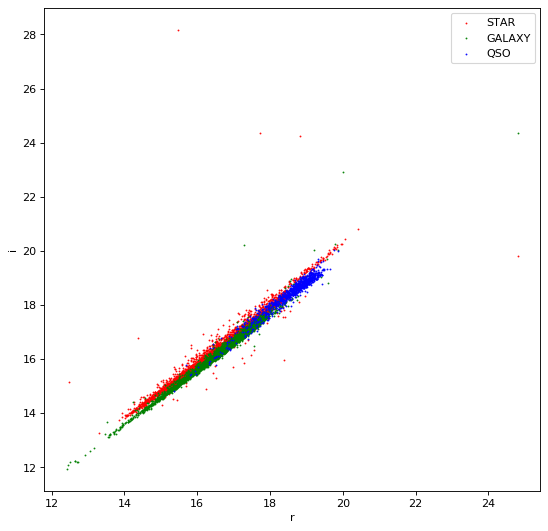

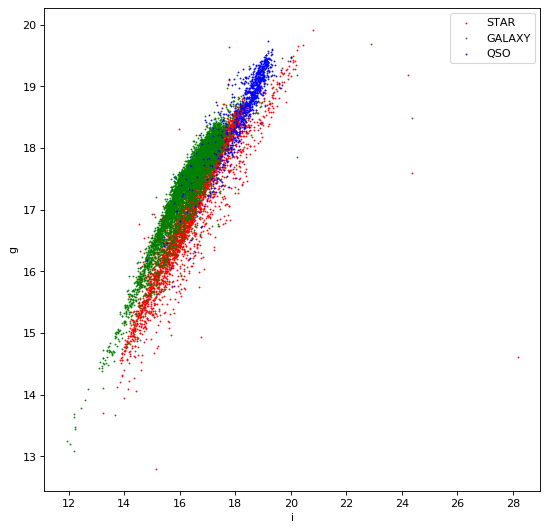

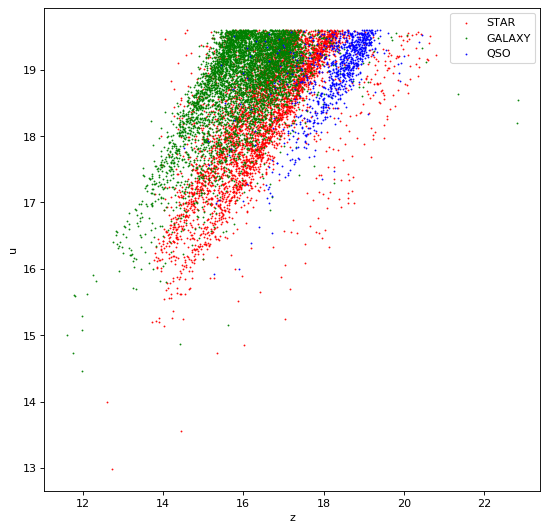

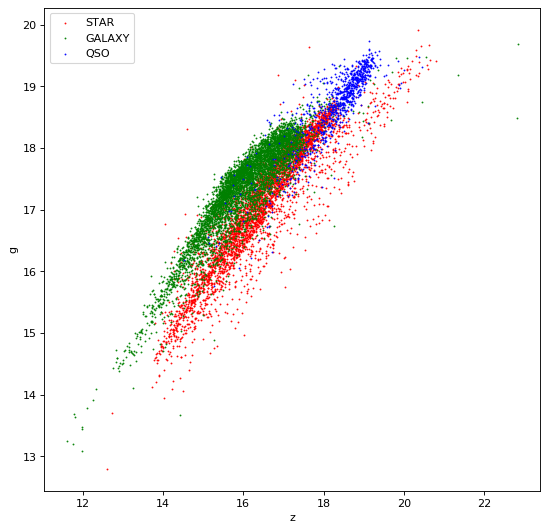

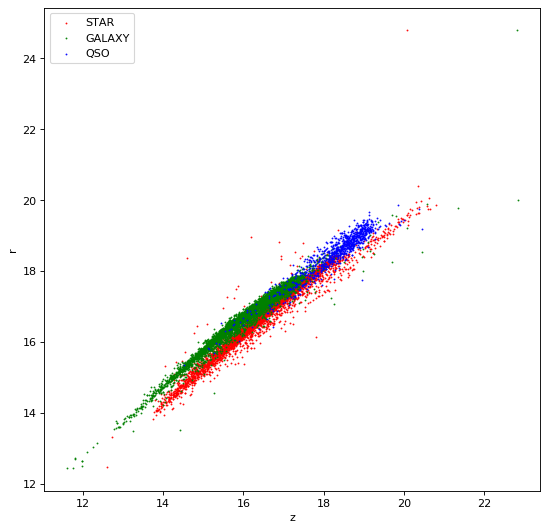

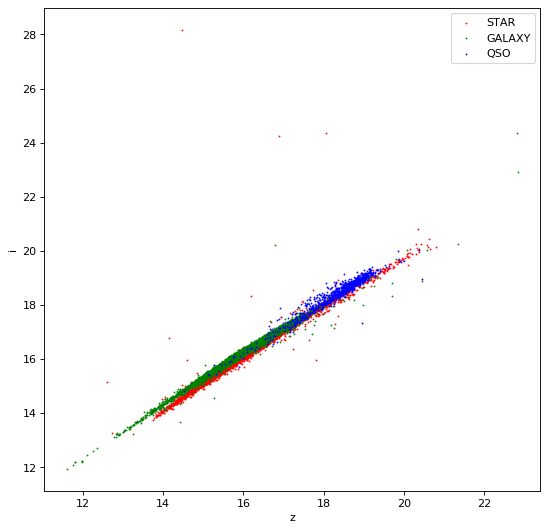

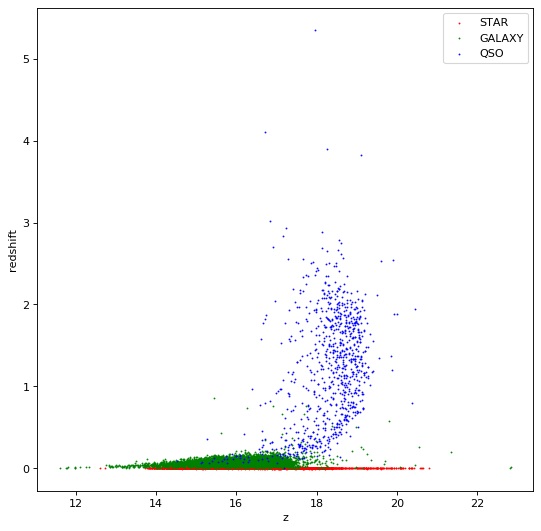

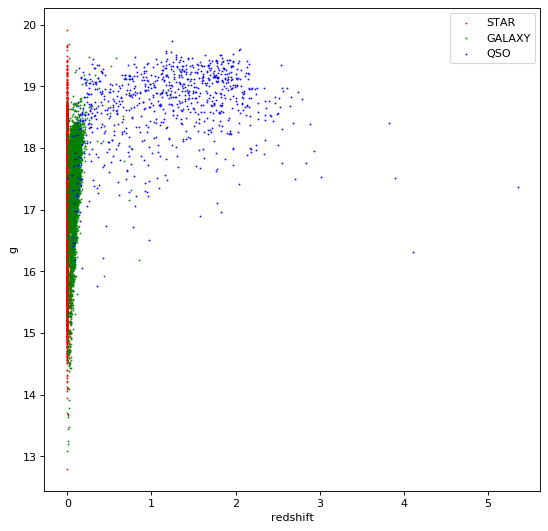

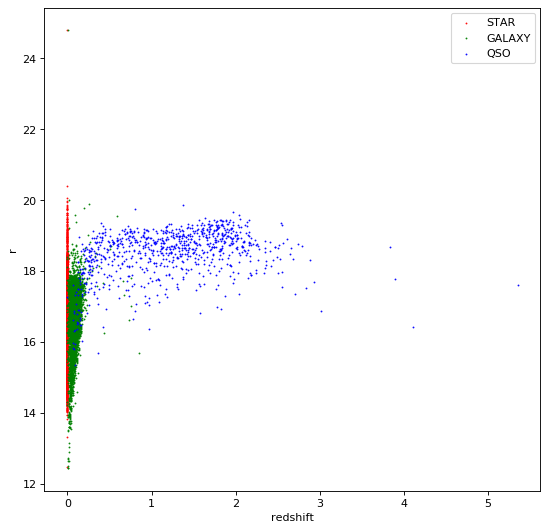

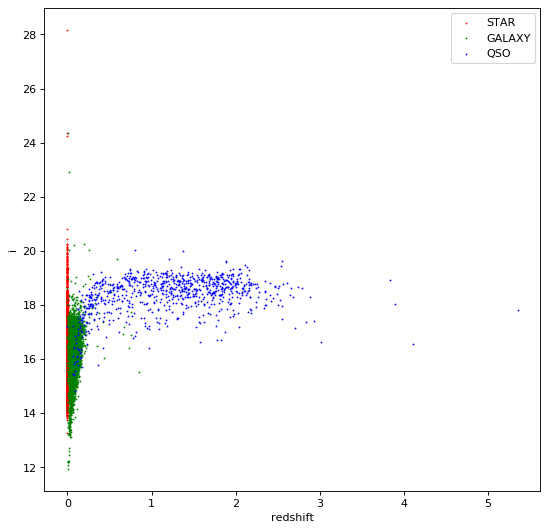

In [4]:
for colX in X.columns:
    for colY in X.columns:
        if colX > colY:
            plt.figure(figsize=(8, 8), dpi=80)
            plt.scatter(x=X[colX][Y=='STAR'], y=X[colY][Y=='STAR'], c="red",s=0.4)
            plt.scatter(x=X[colX][Y=='GALAXY'], y=X[colY][Y=='GALAXY'],c="green",s=0.4)
            plt.scatter(x=X[colX][Y=='QSO'], y=X[colY][Y=='QSO'],c="blue",s=0.4)
            plt.legend(["STAR", "GALAXY","QSO"])
            plt.xlabel(colX)
            plt.ylabel(colY)
            plt.show()


A simple vista podemos observar que los parámetros <b>redshift</b>, <b>z</b>, <b>r</b>, <b>i</b> y <b>g</b> son bastante útiles para poder diferenciar las clases.

Por ejemplo, podemos intuir que:

* Las estrellas se encuentran más cercanas a la Tierra, luego las galaxias y por último los cuasares.
* Las galaxias tienden a emitir menor cantidad del especto infrarrojo lejano.
* Las estrellas tienden a emitir mayor espectro rojo que las galaxias, pero menos que los cuasares.



## Preprocesamiento del Dataset

Buscaremos posibles errores en el dataset, los cuales intentaremos corregir.

### Datos Faltantes

Verificamos que no falten datos.

In [5]:
print("Datos faltantes en el parámetro class:",Y.isnull().sum())

for col in X.columns:
    print("Datos faltantes en el parámetro",col,":",X[col].isnull().sum())


Datos faltantes en el parámetro class: 0
Datos faltantes en el parámetro u : 0
Datos faltantes en el parámetro g : 0
Datos faltantes en el parámetro r : 0
Datos faltantes en el parámetro i : 0
Datos faltantes en el parámetro z : 0
Datos faltantes en el parámetro redshift : 0


Observamos que no faltan datos.

### Tipo de Datos
Varificamos que la columna <b>class</b> solo contenga valores <i>'STAR'</i>, <i>'GALAXY'</i> o <i>'QSO'</i> de tipo <b>string</b>, y que las variables predictivas sean todas de tipo <b>float</b>.

In [6]:
# Validamos parámetro 'class'
errors = 0
for value in Y:
    if( type(value) is not str or value not in ['STAR','GALAXY','QSO'] ):
        errors = errors + 1

print("Errores encontrados en Y:",errors)

# Validamos parámetros de X
errors = 0
for col in X.columns:
    for value in X[col]:
        if( type(value) is not float):
            errors = errors + 1

print("Errores encontrados en X:",errors)

Errores encontrados en Y: 0
Errores encontrados en X: 0


Observamos que todos los datos son correctos.

## Balance de las clases

Medimos la cantidad de observaciones por clase.

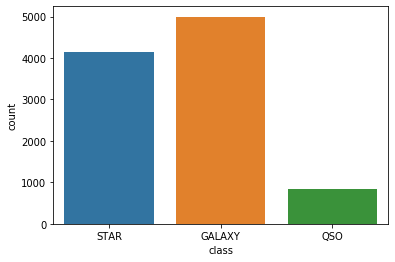

In [7]:
# Verificamos equilibrio
sn.countplot(x="class", data=df)
plt.show()

Observamos que existe un gran desiquilibrio, sobre todo en la cantidad de la clase <b>QSO</b>.<br>
Aplicaremos <i>undersampling</i> a la clase <b>GALAXY</b> para igualar la cantidad a la clase <b>STAR</b>, y aplicaremos <i>oversampling</i> a las clase <b>QSO</b> también para igualar a la clase <b>GALAXY</b>.

### Aplicando Undersampling

Utilizamos el algorimo <b>NearMiss</b> para aplicar undersampling a la clase <b>GALAXY</b>.

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64


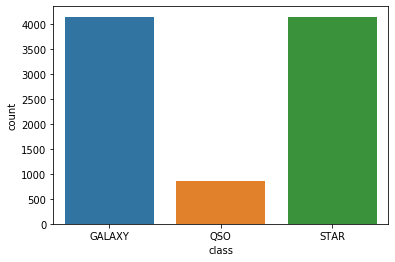

In [8]:
count = df['class'].value_counts()
print(count)

nm = NearMiss(sampling_strategy={"STAR":count["STAR"],"GALAXY":count["STAR"],"QSO":count["QSO"]})
X_under, y_under = nm.fit_resample(X, Y)

# Verificamos equilibrio
data = X_under.copy()
data["class"]=y_under
sn.countplot(x="class",data=data)
plt.show()


### Aplicando Oversampling

Utilizamos el algorimo <b>SMOTE</b> para aplicar oversampling a la clase <b>QSO</b>.

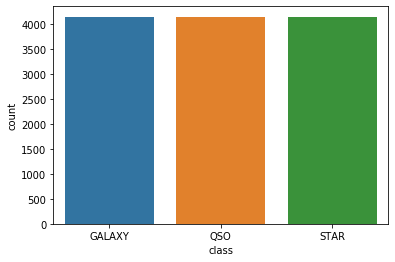

In [9]:
smote = SMOTE()
X_res, Y_res = smote.fit_resample(X_under, y_under)
data = X_res.copy()
data["class"]=Y_res

# Verificamos equilibrio
sn.countplot(x="class",data=data)
plt.show()

### Normalización de las Variables

Debido que las variables <b>u</b>, <b>g</b>, <b>r</b>, <b>i</b>, <b>z</b> poseen un rango dinámico, distinto al de <b>redshift</b>, se pocederá a normalizar los valores, con el fin de igualar el grado de "importancia" de cada variable. 

In [10]:
# Normalizamos datos
scaler = StandardScaler()
X_normalized_num = scaler.fit_transform(X_res.values)
X_normalized = pd.DataFrame(data=X_normalized_num,columns=X_res.columns)

### División del Dataset
Como primera instancia, dividiremos el Dataset, en un 70% para entrenar los modelos y un 30% para testearlos.<br>
Más adelante volveremos a entrenar los modelos, pero utilizando <i>Cross Validation</i>.

In [11]:
# Dividimos dataset en testeo y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X_normalized, Y_res, test_size = .3, random_state=25)

# Regresión Logística

El primer algorimo que utilizaremos será Regresión Logística.

Exactitud: 0.9671980731735291
              precision    recall  f1-score   support

      GALAXY       0.95      0.93      0.94      1260
         QSO       0.99      0.97      0.98      1229
        STAR       0.94      0.98      0.96      1248

    accuracy                           0.96      3737
   macro avg       0.96      0.96      0.96      3737
weighted avg       0.96      0.96      0.96      3737



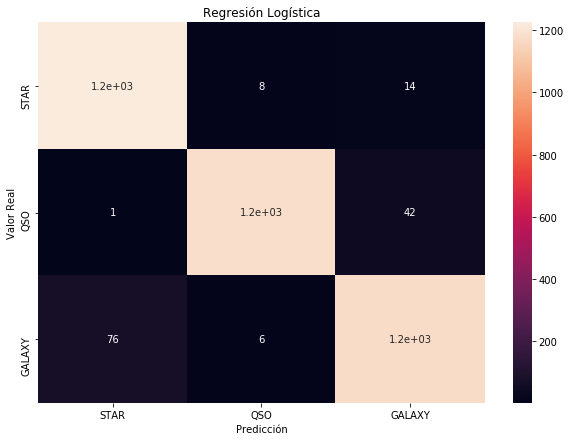

In [12]:
# Entrenamos el modelo
reg_model = LogisticRegression(max_iter=10000)
reg_model.fit(X_train,y_train)

# Lo probamos
y_predicted = reg_model.predict(X_test)

# Función para mostrar rendimiento de los modelos
def resultados(test, pred, title):
    labels = pd.factorize(df['class'])
    cm = confusion_matrix(test, pred,["STAR","QSO","GALAXY"])

    plt.figure(figsize = (10,7))

    ax = plt.subplot()
    sn.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel("Predicción");
    ax.set_ylabel("Valor Real"); 

    ax.set_title(title); 
    ax.xaxis.set_ticklabels(["STAR","QSO","GALAXY"]); 
    ax.yaxis.set_ticklabels(["STAR","QSO","GALAXY"]);
    
    # Analizamos su eficiencia
    print(metrics.classification_report(test,pred))

# Mostramos resultados de la prueba
print("Exactitud:",reg_model.score(X_train, y_train))
resultados(y_test, y_predicted, "Regresión Logística")

Observamos que su precisión general es aceptable, es muy bueno diferenciando cuasares con estrellas, pero tiende a confundir las galaxias con las estrellas, y los quasares con las galaxias.

<h1>K-Nearest Neighbors</h1>

Exactitud: 0.9724739075582062
              precision    recall  f1-score   support

      GALAXY       0.96      0.93      0.94      1260
         QSO       0.98      0.98      0.98      1229
        STAR       0.94      0.98      0.96      1248

    accuracy                           0.96      3737
   macro avg       0.96      0.96      0.96      3737
weighted avg       0.96      0.96      0.96      3737



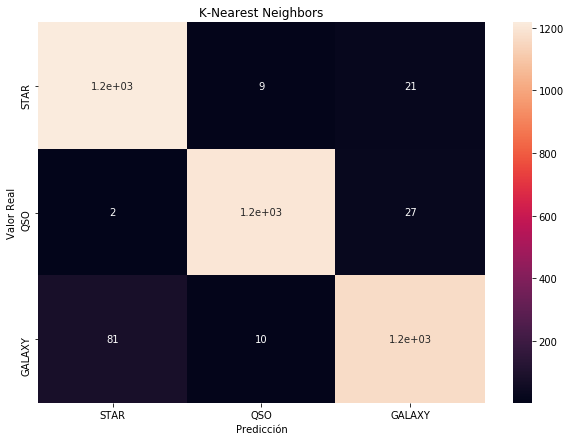

In [13]:
# Entrenamos modelo
knn = neighbors.KNeighborsClassifier()
knn.fit(X_train,y_train)

# Lo probamos
y_predicted = knn.predict(X_test)

# Analizamos resultados
print("Exactitud:",knn.score(X_train, y_train))
resultados(y_test, y_predicted,"K-Nearest Neighbors")

Al igual que con Regresión Logistica, es muy bueno diferenciando cuasares con estrellas, pero suele equivocarse más excepto al identificar cuasares como galaxias.

## Árbol de Decisión

Exactitud: 1.0
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98      1260
         QSO       0.99      0.97      0.98      1229
        STAR       1.00      1.00      1.00      1248

    accuracy                           0.98      3737
   macro avg       0.98      0.98      0.98      3737
weighted avg       0.98      0.98      0.98      3737



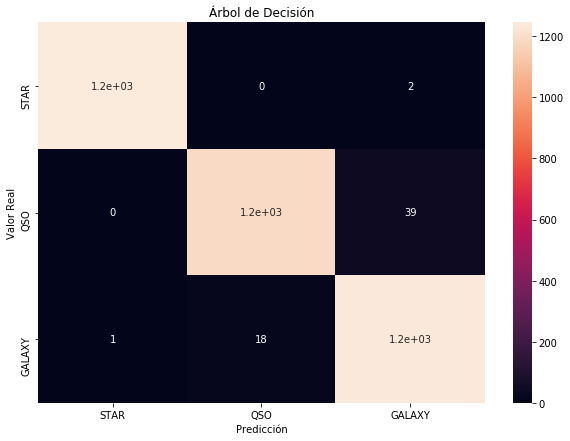

In [14]:
# Entrenamos el modelo
d_tree = DecisionTreeClassifier()
d_tree.fit(X_train,y_train)

y_predicted = d_tree.predict(X_test)
print("Exactitud:",d_tree.score(X_train, y_train))
resultados(y_test, y_predicted, "Árbol de Decisión")

Observamos que es el algoritmo más preciso de los tres, es excelente detectando estrellas, con un 100% de precisión, y solo tiene problemas detectando galaxias y cuasares.

## Cross Validation
Ahora, volveremos a entrenar los modelos, pero utilizando Cross Validation, con el objetivo de encontrar la división del dataset que mejor entrena a cada uno.
Utilizaremos la exactitud promedio (Acurracy) para evaluar las divisiones.

In [15]:
def cross_val(X,Y,model,name):
    # Parámetos que gardaremos
    divisiones = 2
    acurracy = 0
    y_test_f = 0
    y_pred_f = 0
    
    # Loop para distinta cantidad de divisiones
    for divs in range(2,15):
        kf = KFold(n_splits=divs,shuffle=True,random_state=1)
        # Obtenemos índices
        for train_ixs,test_ixs in kf.split(X):
            
            # Se divide el dataset
            X_train, X_test = X.iloc[train_ixs],X.iloc[test_ixs]
            y_train, y_test = Y.iloc[train_ixs],Y.iloc[test_ixs]
            
            # Lo evaluamos
            model.fit(X_train,y_train)
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test,y_pred)            
            
            # Si es mejor que los anteriores se almacena
            if(acc > acurracy):
                y_test_f = y_test.copy()
                y_pred_f = y_pred.copy()
                acurracy = acc
                divisiones = divs
    
    print(name)
    print("Divisiones:",divisiones)
    print("Exactitud:",acurracy)
    print()
    resultados(y_test_f, y_pred_f, name)
    return model
            

La función anterior, analiza el comportamiento de los modelos, dividendo el dataset en 2, 3, 4 . . .hasta 15 veces.<br>
En cada selección de número de divisiones, itera, estableciendo a cada una de las divisiones como la fracción de prueba.

## Evaluando Modelos con Cross Validation

Regresión Logística
Divisiones: 10
Exactitud: 0.976706827309237

              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96       397
         QSO       1.00      0.98      0.99       438
        STAR       0.96      0.99      0.98       410

    accuracy                           0.98      1245
   macro avg       0.98      0.98      0.98      1245
weighted avg       0.98      0.98      0.98      1245



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

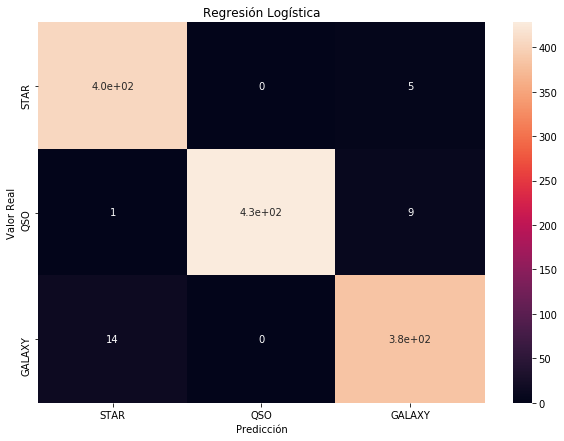

In [16]:
#Regresión Logística
cross_val(X_normalized, Y_res,LogisticRegression(max_iter=10000),"Regresión Logística")

K-Nearest Neighbors
Divisiones: 10
Exactitud: 0.9751004016064257

              precision    recall  f1-score   support

      GALAXY       0.98      0.94      0.96       397
         QSO       0.99      0.99      0.99       438
        STAR       0.96      0.99      0.97       410

    accuracy                           0.98      1245
   macro avg       0.98      0.97      0.97      1245
weighted avg       0.98      0.98      0.98      1245



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

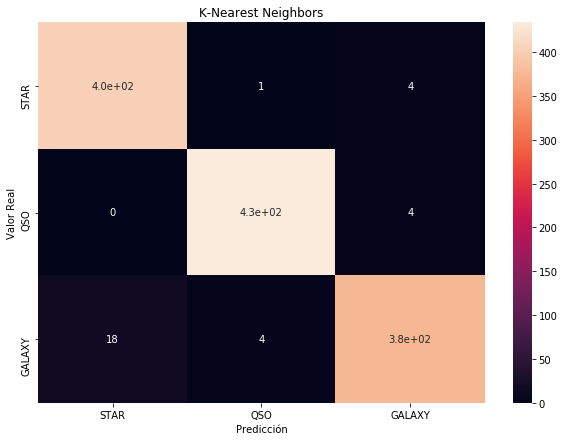

In [17]:
# K-Nearest Neighbors
cross_val(X_normalized, Y_res,neighbors.KNeighborsClassifier(),"K-Nearest Neighbors")

Árbol de Decisión
Divisiones: 14
Exactitud: 0.9910112359550561

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.99       280
         QSO       0.99      0.99      0.99       290
        STAR       1.00      0.99      1.00       320

    accuracy                           0.99       890
   macro avg       0.99      0.99      0.99       890
weighted avg       0.99      0.99      0.99       890



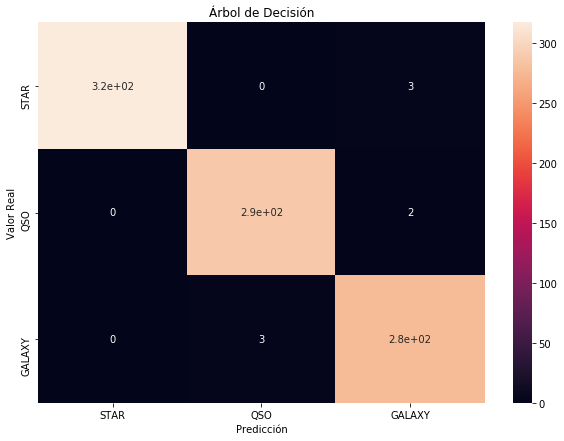

In [18]:
# Árbol de Decisión
treeModel = cross_val(X_normalized, Y_res,DecisionTreeClassifier(),"Árbol de Decisión")

Podemos notar un aumento en la exactitud promedio de todos los modelos, también se observa que el tamaño de entrenamiento (calculado por el número de divisiones) elegido por todos los algoritmos fue mayor que el 70% (que se habia asignado inicialmente), sobre todo en el algoritmo de Árbol de Decisión.


## Comparando Modelos

### Calidad

1. Árbol de Decisión
2. Regresión Lineal
3. K-Nearest Neighbors

El algoritmo que acierta la mayor cantidad de veces, en todas las clases es el Árbol de Decisión.<br>
Lo sigue la Regresión Lineal y por último K-Nearest Neighbors.

### Rendimiento

1. Regresión Lineal
2. Árbol de Decisión
3. K-Nearest Neighbors

El algoritmo de Regresión Lineal brinda el mejor equilibrio entre rendimiento/calidad, ya que al momento de realizar predicciones es bastante certero, y a la vez requiere de poco computo para realizarlas.
El algoritmo de Árbol de Decisión es el más exacto de los 3, sin embargo el orden para realizar predicciones es O(n^2), por lo tanto, para alturas muy grandes puede resultar, bastante lento de calcular.
El algoritmo K-Nearest Neighbors resulta ser el peor de los 3, es el más inexacto y a su vez es bastante lento, debido a que debe calcular n cantidad de distancias cada vez que se utiliza. 




# Conclusión

Analizando los resultados y los gráficos de relaciones entre variables y clases, podemos concluir que los Cuasares son facilmente diferenciables gracias a la variable redshift (Distancia a la Tierra), no así las estrellas con galaxias, que no lo son con ningún parámetro en concreto, de aquí se intuye que el algoritmo Árbol de Decisión permite clasificar de mejor manera los problemas donde no existe gran diferencia entre las clases.